In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Concatenate, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import cv2

/Users/ninad/Projects/RBCSolveit/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
np.random.seed(42)
tf.random.set_seed(42)

IMAGE_DIR = '../ISIC-images'
METADATA_PATH = '../ISIC-images/metadata.csv'

# Image dimensions
IMG_WIDTH, IMG_HEIGHT = 224, 224

In [3]:
metadata = pd.read_csv(METADATA_PATH)
print(f"Total records: {len(metadata)}")
metadata.head()

Total records: 2550


,isic_id,attribution,copyright_license,acquisition_day,age_approx,anatom_site_general,anatom_site_special,benign_malignant,clin_size_long_diam_mm,concomitant_biopsy,...,image_type,lesion_id,mel_class,mel_thick_mm,mel_ulcer,melanocytic,nevus_type,patient_id,personal_hx_mm,sex
0,ISIC_0009868,Anonymous,CC-0,NaN,70,posterior torso,NaN,malignant,4.0,True,...,dermoscopic,NaN,NaN,NaN,NaN,True,NaN,NaN,False,female
1,ISIC_0009869,Anonymous,CC-0,NaN,40,posterior torso,NaN,benign,4.0,True,...,dermoscopic,NaN,NaN,NaN,NaN,True,NaN,NaN,True,female
2,ISIC_0009870,Anonymous,CC-0,NaN,40,upper extremity,NaN,benign,3.0,True,...,dermoscopic,NaN,NaN,NaN,NaN,True,NaN,NaN,True,female
3,ISIC_0009871,Anonymous,CC-0,NaN,45,posterior torso,NaN,benign,5.0,True,...,dermoscopic,NaN,NaN,NaN,NaN,True,NaN,NaN,False,male
4,ISIC_0009872,Anonymous,CC-0,NaN,50,head/neck,NaN,benign,3.0,True,...,dermoscopic,NaN,NaN,NaN,NaN,True,NaN,NaN,False,female


In [4]:
metadata.columns

Index(['isic_id', 'attribution', 'copyright_license', 'acquisition_day',
       'age_approx', 'anatom_site_general', 'anatom_site_special',
       'benign_malignant', 'clin_size_long_diam_mm', 'concomitant_biopsy',
       'dermoscopic_type', 'diagnosis_1', 'diagnosis_2', 'diagnosis_3',
       'diagnosis_4', 'diagnosis_5', 'diagnosis_confirm_type', 'family_hx_mm',
       'fitzpatrick_skin_type', 'image_type', 'lesion_id', 'mel_class',
       'mel_thick_mm', 'mel_ulcer', 'melanocytic', 'nevus_type', 'patient_id',
       'personal_hx_mm', 'sex'],
      dtype='object')

In [5]:
print(metadata['benign_malignant'].value_counts())

print("Missing values per column:")
print(metadata.isnull().sum())

benign_malignant
benign                     2015
malignant                   468
indeterminate/benign         33
indeterminate/malignant      21
indeterminate                 9
Name: count, dtype: int64
Missing values per column:
isic_id                      0
attribution                  0
copyright_license            0
acquisition_day           1613
age_approx                   0
anatom_site_general          0
anatom_site_special       2537
benign_malignant             4
clin_size_long_diam_mm       0
concomitant_biopsy          26
dermoscopic_type          1695
diagnosis_1                  1
diagnosis_2                333
diagnosis_3                372
diagnosis_4               1320
diagnosis_5               1945
diagnosis_confirm_type       5
family_hx_mm                 0
fitzpatrick_skin_type     1924
image_type                   0
lesion_id                 1613
mel_class                 2455
mel_thick_mm              2504
mel_ulcer                 2510
melanocytic               

In [6]:
print("Original distribution:")
print(metadata['benign_malignant'].value_counts())

indeterminate_values = ['indeterminate', 'indeterminate/benign', 'indeterminate/malignant']
# Filter the DataFrame to keep only benign and malignant values
metadata_filtered = metadata[~metadata['benign_malignant'].isin(indeterminate_values)]
print("Filtered distribution:")
print(metadata_filtered['benign_malignant'].value_counts())
print(f"Removed {len(metadata) - len(metadata_filtered)} rows")

# Update the metadata DataFrame
metadata = metadata_filtered

Original distribution:
benign_malignant
benign                     2015
malignant                   468
indeterminate/benign         33
indeterminate/malignant      21
indeterminate                 9
Name: count, dtype: int64
Filtered distribution:
benign_malignant
benign       2015
malignant     468
Name: count, dtype: int64
Removed 63 rows


In [7]:
selected_features = ['anatom_site_general', 'dermoscopic_type', 'fitzpatrick_skin_type', 'sex', 'age_approx', 'clin_size_long_diam_mm']

In [8]:
def load_and_preprocess_image(img_path, target_size=(IMG_WIDTH, IMG_HEIGHT)):
    """Load and preprocess an image for the CNN branch with segmentation masking."""
    try:
        img_bgr = cv2.imread(img_path)
        if img_bgr is None:
            raise Exception(f"Failed to load image: {img_path}")
            
        # Resize image to target size
        img_bgr = cv2.resize(img_bgr, (target_size[1], target_size[0]))
        
        # Convert to RGB
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        
        # Create grayscale version for mask generation
        img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
        
        # Apply Gaussian blur
        img_blur = cv2.GaussianBlur(img_gray, (5, 5), 0)
        
        # Apply Otsu thresholding to create a binary mask
        _, seg_mask = cv2.threshold(img_blur, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        
        # Invert the mask
        seg_mask_inv = cv2.bitwise_not(seg_mask)
        
        # Apply the mask to the original image
        masked_img = cv2.bitwise_and(img_rgb, img_rgb, mask=seg_mask_inv)
        
        # Normalize the image
        normalized_img = masked_img / 255.0
        
        return normalized_img
    except Exception as e:
        print(f"Error processing image {img_path}: {e}")
        # Return a blank image if error
        return np.zeros((target_size[0], target_size[1], 3))

def preprocess_metadata(df, selected_features, target_col='benign_malignant'):
    """Preprocess metadata for the MLP branch."""
    # Drop rows with missing target or missing isic_id
    df = df.dropna(subset=[target_col, 'isic_id'])
    
    # Create a copy with only the selected features and target
    df_selected = df[selected_features + [target_col]].copy()
    
    # Split features and target
    X = df_selected.drop(columns=[target_col])
    y = df_selected[target_col]
    
    # Encode target
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    
    # Identify numeric and categorical columns
    numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
    categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
    
    # Create preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', Pipeline([
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())
            ]), numeric_cols),
            ('cat', Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('onehot', OneHotEncoder(handle_unknown='ignore'))
            ]), categorical_cols)
        ],
        remainder='drop'
    )
    
    # Fit and transform
    X_processed = preprocessor.fit_transform(X)
    return X_processed, y_encoded, preprocessor, le, df['isic_id'].values

In [9]:
def visualize_preprocessing(img_path):
    """Visualize the steps of image preprocessing."""
    # Load the image
    img_bgr = cv2.imread(img_path)
    img_bgr = cv2.resize(img_bgr, (IMG_WIDTH, IMG_HEIGHT))
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    
    # Create grayscale version
    img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    
    # Apply Gaussian blur
    img_blur = cv2.GaussianBlur(img_gray, (5, 5), 0)
    
    # Apply Otsu thresholding
    _, seg_mask = cv2.threshold(img_blur, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    # Invert the mask
    seg_mask_inv = cv2.bitwise_not(seg_mask)
    
    # Apply the mask to the original image
    masked_img = cv2.bitwise_and(img_rgb, img_rgb, mask=seg_mask_inv)
    
    # Create a figure with subplots
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Display original image
    axes[0, 0].imshow(img_rgb)
    axes[0, 0].set_title('Original Image')
    
    # Display grayscale image
    axes[0, 1].imshow(img_gray, cmap='gray')
    axes[0, 1].set_title('Grayscale')
    
    # Display blurred image
    axes[0, 2].imshow(img_blur, cmap='gray')
    axes[0, 2].set_title('Gaussian Blur')
    
    # Display thresholded mask
    axes[1, 0].imshow(seg_mask, cmap='gray')
    axes[1, 0].set_title('Binary Mask')
    
    # Display inverted mask
    axes[1, 1].imshow(seg_mask_inv, cmap='gray')
    axes[1, 1].set_title('Inverted Mask')
    
    # Display final masked image
    axes[1, 2].imshow(masked_img)
    axes[1, 2].set_title('Masked Image')
    
    plt.tight_layout()
    plt.show()
    
    return masked_img / 255.0 

In [10]:
print("Preprocessing metadata")
X_meta, y, preprocessor, label_encoder, isic_ids = preprocess_metadata(metadata, selected_features)
print(f"Metadata shape after preprocessing: {X_meta.shape}")
print(f"Number of classes: {len(np.unique(y))}")

# Create image paths
image_paths = [os.path.join(IMAGE_DIR, f"{id}.jpg") for id in isic_ids]
print("Splitting data into train and test sets")
X_meta_train, X_meta_test, X_img_paths_train, X_img_paths_test, y_train, y_test = train_test_split(
    X_meta, image_paths, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {len(X_meta_train)}")
print(f"Test set size: {len(X_meta_test)}")

Preprocessing metadata
Metadata shape after preprocessing: (2483, 18)
Number of classes: 2
Splitting data into train and test sets
Training set size: 1986
Test set size: 497


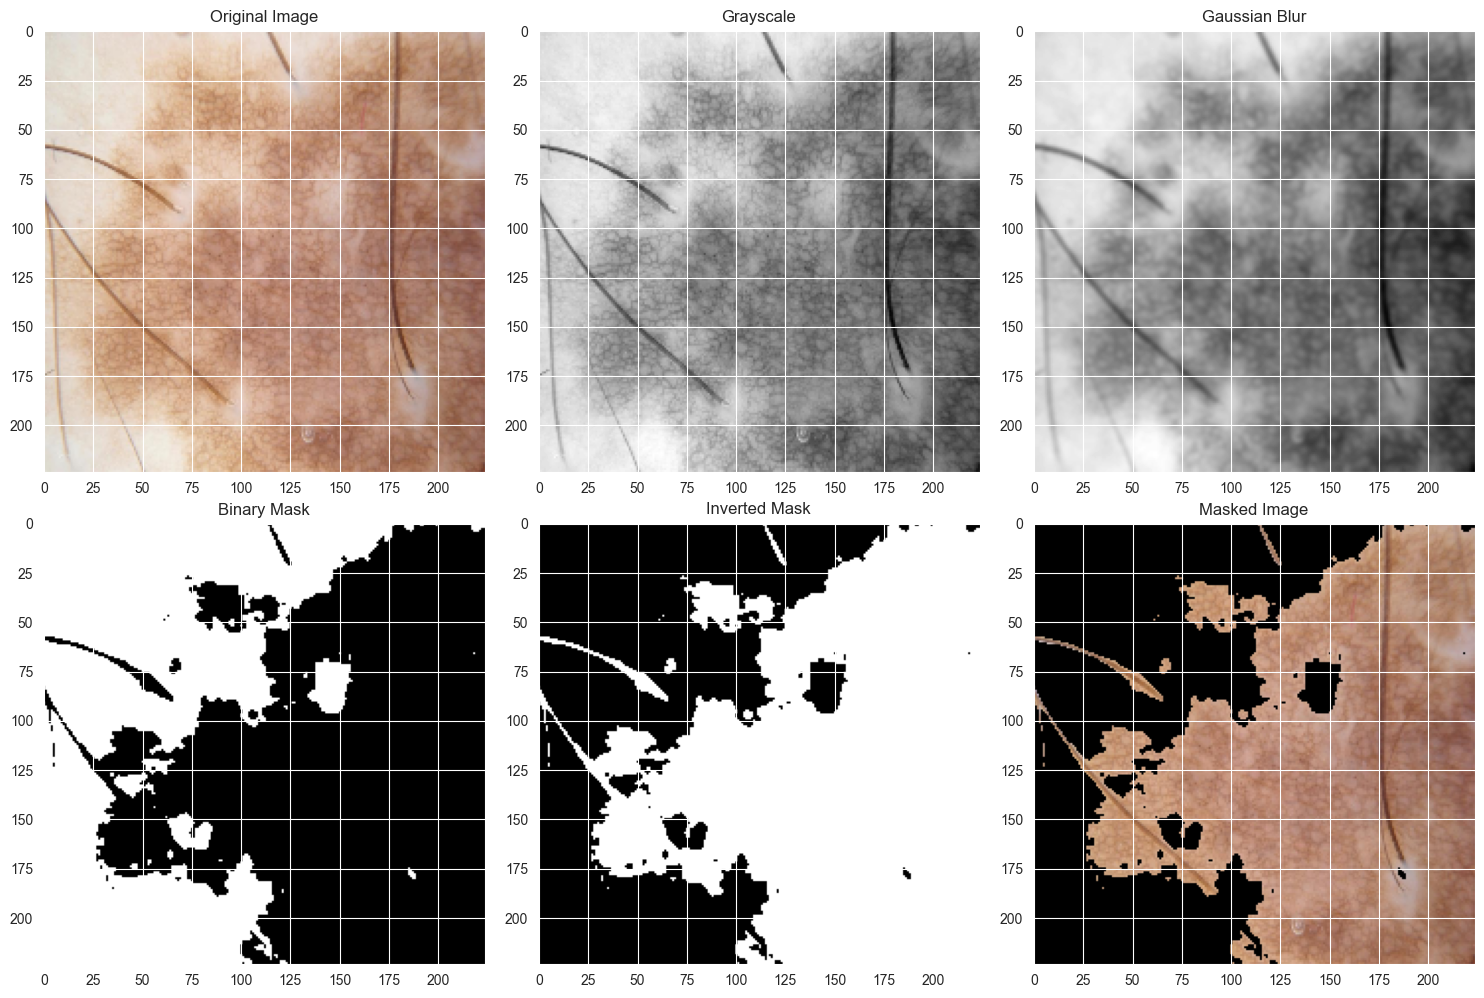

In [11]:
# Test the visualization on one sample image
if len(X_img_paths_train) > 0:
    sample_path = X_img_paths_train[0]
    visualize_preprocessing(sample_path)

In [12]:
MAX_IMAGES = 1000  # Adjust as needed
if len(X_img_paths_train) > MAX_IMAGES:
    print(f"Limiting training set to {MAX_IMAGES} images for memory constraints")
    indices = np.random.choice(len(X_img_paths_train), MAX_IMAGES, replace=False)
    X_img_paths_train = [X_img_paths_train[i] for i in indices]
    X_meta_train = X_meta_train[indices]
    y_train = y_train[indices]

if len(X_img_paths_test) > MAX_IMAGES // 5:
    test_size = MAX_IMAGES // 5
    print(f"Limiting test set to {test_size} images")
    indices = np.random.choice(len(X_img_paths_test), test_size, replace=False)
    X_img_paths_test = [X_img_paths_test[i] for i in indices]
    X_meta_test = X_meta_test[indices]
    y_test = y_test[indices]

print("Loading images")
X_img_train = np.array([load_and_preprocess_image(path) for path in X_img_paths_train])
X_img_test = np.array([load_and_preprocess_image(path) for path in X_img_paths_test])

print(f"Image data shape: {X_img_train.shape}")
print(f"Metadata shape: {X_meta_train.shape}")

Limiting training set to 1000 images for memory constraints
Limiting test set to 200 images
Loading images
Image data shape: (1000, 224, 224, 3)
Metadata shape: (1000, 18)


In [13]:
def create_cnn_branch(input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)):
    """Create CNN branch for image data."""
    # Use a pre-trained model as the base
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Freeze the base model
    base_model.trainable = False
    
    # Create the CNN branch
    inputs = Input(shape=input_shape)
    x = base_model(inputs)
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    
    return inputs, x

def create_mlp_branch(input_dim):
    """Create MLP branch for metadata."""
    inputs = Input(shape=(input_dim,))
    x = Dense(128, activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    return inputs, x

def create_mixed_input_model(img_shape=(IMG_WIDTH, IMG_HEIGHT, 3), meta_dim=None, num_classes=2):
    """Create a model with both CNN and MLP branches."""
    # Create branches
    img_input, cnn_output = create_cnn_branch(img_shape)
    meta_input, mlp_output = create_mlp_branch(meta_dim)
    
    # Combine branches
    combined = Concatenate()([cnn_output, mlp_output])
    
    # Add final layers
    x = Dense(128, activation='relu')(combined)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    # Add output layer based on number of classes
    if num_classes == 2:
        output = Dense(1, activation='sigmoid')(x)
        loss = 'binary_crossentropy'
    else:
        output = Dense(num_classes, activation='softmax')(x)
        loss = 'sparse_categorical_crossentropy'
    
    # Create model
    model = Model(inputs=[img_input, meta_input], outputs=output)
    
    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

In [14]:
print("Creating mixed input model")
num_classes = len(np.unique(y))
meta_dim = X_meta_train.shape[1]
mixed_model = create_mixed_input_model(meta_dim=meta_dim, num_classes=num_classes)

mixed_model.summary()

Creating mixed input model


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 18)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │      2,432 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128)       │        512 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobilenetv2_1.00_2… │ (None, 7, 7,      │  2,257,984 │ input_layer_1[0]… │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ mobilenetv2_1.00… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      8,256 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    327,936 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 320)       │          0 │ dropout[0][0],    │
│ (Concatenate)       │                   │            │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │     41,088 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_3[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1)         │        129 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,639,105 (10.07 MB)

 Trainable params: 380,481 (1.45 MB)

 Non-trainable params: 2,258,624 (8.62 MB)

In [15]:
checkpoint = ModelCheckpoint(
    'skin_lesion_classifier_image_seg_max_accuracy.keras',  # .keras extension
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

print("Training model")
history = mixed_model.fit(
    [X_img_train, X_meta_train], y_train,
    validation_data=([X_img_test, X_meta_test], y_test),
    batch_size=32,
    epochs=20,
    callbacks=[checkpoint, early_stopping]
)

Training model
Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 898ms/step - accuracy: 0.5823 - loss: 0.9348
Epoch 1: val_accuracy improved from -inf to 0.77500, saving model to skin_lesion_classifier_image_seg_max_accuracy.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.5832 - loss: 0.9330 - val_accuracy: 0.7750 - val_loss: 0.4798
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 941ms/step - accuracy: 0.6280 - loss: 0.6923
Epoch 2: val_accuracy did not improve from 0.77500
32/32 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.6291 - loss: 0.6912 - val_accuracy: 0.7750 - val_loss: 0.4718
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 893ms/step - accuracy: 0.7163 - loss: 0.6047
Epoch 3: val_accuracy improved from 0.77500 to 0.82500, saving model to skin_lesion_classifier_image_seg_max_accuracy.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.7167 - loss: 0.6044 - val_accuracy: 0.8250 - val_loss: 0.4432
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 843ms/step - accuracy: 0.7312 - loss: 0.5856


In [16]:
print("Evaluating model")
evaluation = mixed_model.evaluate([X_img_test, X_meta_test], y_test)
print(f"Test Loss: {evaluation[0]:.4f}")
print(f"Test Accuracy: {evaluation[1]:.4f}")

Evaluating model
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 550ms/step - accuracy: 0.8195 - loss: 0.4049
Test Loss: 0.3731
Test Accuracy: 0.8400


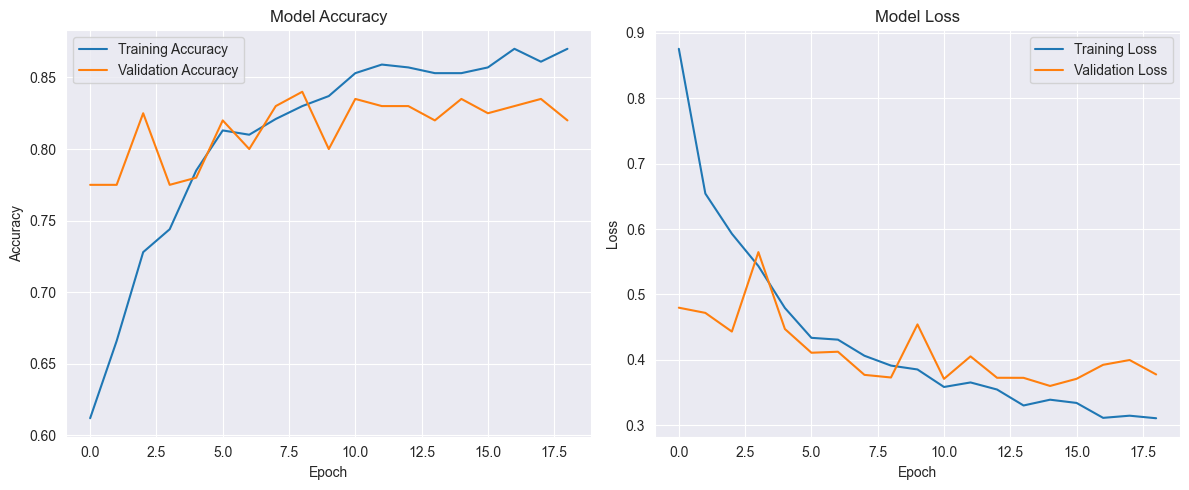

In [17]:
plt.figure(figsize=(12, 5))
# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig('training_history_image_seg_max_accuracy.png')
plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 616ms/step
Precision: 0.8095
Recall: 0.3778


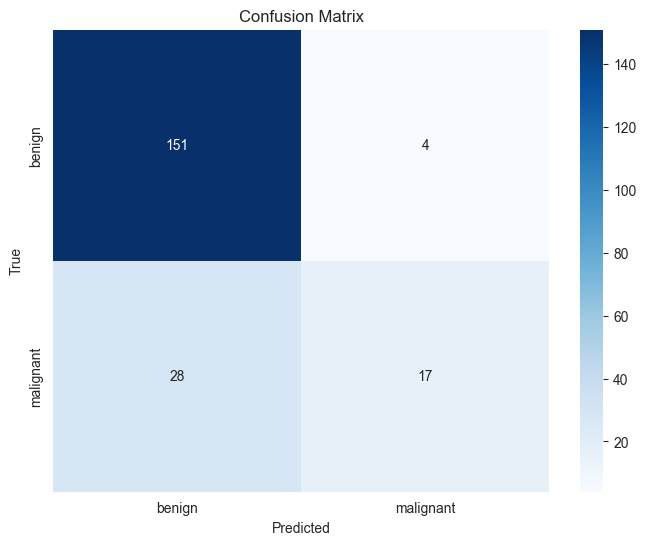

Classification Report:
              precision    recall  f1-score   support

      benign       0.84      0.97      0.90       155
   malignant       0.81      0.38      0.52        45

    accuracy                           0.84       200
   macro avg       0.83      0.68      0.71       200
weighted avg       0.84      0.84      0.82       200


In [18]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report

y_pred_prob = mixed_model.predict([X_img_test, X_meta_test])

# Convert probabilities to binary predictions
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Calculate precision and recall
# Precision: "When the model predicts 'malignant', how often is it correct?"
# Recall: "Of all actual 'malignant' cases, how many did the model catch?"
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Calculate and display confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix_image_seg_max_accuracy.png')
plt.show()

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

In [19]:
# Make predictions on a few examples
predictions = mixed_model.predict([X_img_test[:5], X_meta_test[:5]])

for i in range(5):
    true_label = "Malignant" if y_test[i] == 1 else "Benign"
    if num_classes == 2:
        pred_prob = predictions[i][0]
        pred_label = "Malignant" if pred_prob > 0.5 else "Benign"
        print(f"Example {i+1}: True: {true_label}, Predicted: {pred_label} (Probability: {pred_prob:.4f})")
    else:
        pred_class = np.argmax(predictions[i])
        pred_label = label_encoder.inverse_transform([pred_class])[0]
        print(f"Example {i+1}: True: {true_label}, Predicted: {pred_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Example 1: True: Benign, Predicted: Benign (Probability: 0.2120)
Example 2: True: Benign, Predicted: Benign (Probability: 0.0611)
Example 3: True: Benign, Predicted: Malignant (Probability: 0.5862)
Example 4: True: Malignant, Predicted: Malignant (Probability: 0.7219)
Example 5: True: Benign, Predicted: Benign (Probability: 0.0221)
